# CAB420, Encoders and Decoders, Example 2: Multiple Outputs
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we will look at getting a network to do two things at once. Multi-task learning is generally very common with deep learning architectures. Largely because:
* It's easy 
* It's often very useful

By having multiple outputs we often find that one task can regularise the other, i.e. the model is less likely to overfit and will generalise better. Both tasks don't always need to be super meaninful either, we can for example have one task that is simply an auto-encoder. This on it's own may not be of use to us, but it can help the other task that we're trying to learn depending on the circumstances.

## Too Long; Didn't Read:
* Multi-task learning is exactly what it sounds like - getting a network to do two things at once
* To do this, we need to setup multiple outputs, and multiple losses. The total loss is just the sum of these
* Generally, if the tasks are related we'll get better performance leanring both than learning either one individually, as one task helps regularise the other
* We can weight the tasks, such that one task is given more importance than the other

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import datetime
import numpy


import keras
from keras import layers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import pydot
import IPython
from IPython.display import SVG
from keras.utils import model_to_dot, plot_model

import cv2

## The Data

We're going to use the same data we used in the one of our early deep convolutional neural network examples. This was a rotated version of MNIST. This time, we'll try to classify both the rotation and the class of digit.

Data preparation will follow exactly the same process as the earlier example.

In [2]:
def rotate(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """
    # Get the image size
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(numpy.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = numpy.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = numpy.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (numpy.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (numpy.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (numpy.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (numpy.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = numpy.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (numpy.matrix(trans_mat) * numpy.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result

def rotate_dataset(input, rot_amount=45):

    out_x = numpy.zeros(input.shape, dtype='float32')
    out_y = numpy.zeros(input.shape[0], dtype='float32')

    for i,image in enumerate(input):

        # get a random angle
        rotation_angle = numpy.random.randint(low=-rot_amount, high=rot_amount)

        # rotate the image
        rotated_image = rotate(image, rotation_angle)

        # add dimension to account for the channels if the image is greyscale
        if rotated_image.ndim == 2:
            rotated_image = numpy.expand_dims(rotated_image, axis=2)

        rotated_image = cv2.resize(rotated_image, (image.shape[1], image.shape[0]))
        
        # store the image and label in their corresponding batches
        out_x[i] = rotated_image
        out_y[i] = rotation_angle       
    
    return out_x, out_y

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train_rot, y_train_rot = rotate_dataset(x_train, 45)
x_train_rot = x_train_rot.reshape(x_train_rot.shape[0], 28, 28, 1)
x_test_rot, y_test_rot = rotate_dataset(x_test, 45)
x_test_rot = x_test_rot.reshape(x_test_rot.shape[0], 28, 28, 1)

## The Network

We're going to keep it simple, and again borrow heavily from the previous example. The only difference is that we now have an extra dense layer, and an extra output.

We set this up such that after the flatten, we have two dense layers, each of the same size, and then our two outputs, one for size 1 (for the rotation angle) and one of size 10 (for the class). Note that when it comes to building the model, the only difference is that we now have two outputs rather than one.

In [4]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = layers.Flatten()(x)
x1 = layers.Dense(64, activation='relu')(x)
angle = layers.Dense(1, name='angle_out')(x1)
x2 = layers.Dense(64, activation='relu')(x)
label = layers.Dense(10, name='class_out')(x2)

model_cnn = keras.Model(inputs=inputs, outputs=[angle, label], name='mnist_cnn_multitask_model')
model_cnn.summary()

Model: "mnist_cnn_multitask_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 28, 28, 1) │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 26, 26, 8) │      80 │ img[0][0]            │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 13, 13, 8) │       0 │ conv2d[0][0]         │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 11, 11,    │   1,168 │ max_pooling2d[0][0]  │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 16)  │       0 │ conv2d_1[0][0]       │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 3, 3, 32)  │   4,640 │ max_pooling2d_1[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ flatten (Flatten)   │ (None, 288)       │       0 │ conv2d_2[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 64)        │  18,496 │ flatten[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │  18,496 │ flatten[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ angle_out (Dense)   │ (None, 1)         │      65 │ dense[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ class_out (Dense)   │ (None, 10)        │     650 │ dense_1[0][0]        │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 43,595 (170.29 KB)

 Trainable params: 43,595 (170.29 KB)

 Non-trainable params: 0 (0.00 B)

Once we start using more complex topologies, the default text based graph that comes from summary() can be a bit hard to go through. Luckily we've been drawing pictures of networks thoughout our previous examples, and we'll lean more on these with the more complex networks.

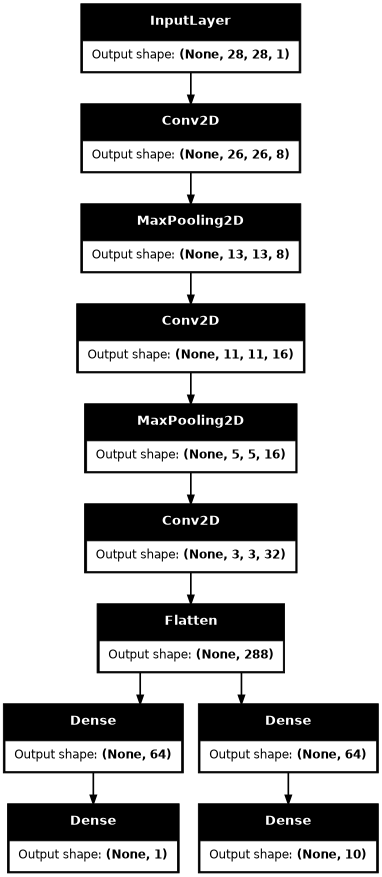

In [5]:
plot_model(model_cnn, show_shapes=True, dpi=60)

The last step is our losses. This is again really simple, all we do is provide a list of them. If we have named our outputs, we could also do this via a dictionary.

Afer that, we can train our models as per usual.

In [6]:
model_cnn.compile(loss=['mean_squared_error', keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
                  optimizer=keras.optimizers.RMSprop(), 
                  # keras won't give me details for both losses by default, so I'm adding metrics for
                  # each loss to get the individual loss values
                  metrics=['mean_squared_error', keras.losses.SparseCategoricalCrossentropy(from_logits=True)], 
                  jit_compile=False)

In [7]:
history = model_cnn.fit(x_train_rot, [y_train_rot, y_train],
                    batch_size=64,
                    epochs=20,
                    validation_data=(x_test_rot, [y_test_rot, y_test]))

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - angle_out_mean_squared_error: 290.5691 - class_out_sparse_categorical_crossentropy: 2.6714 - loss: 293.2404 - val_angle_out_mean_squared_error: 127.8859 - val_class_out_sparse_categorical_crossentropy: 0.3456 - val_loss: 128.2315
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - angle_out_mean_squared_error: 112.3345 - class_out_sparse_categorical_crossentropy: 0.2934 - loss: 112.6278 - val_angle_out_mean_squared_error: 111.2802 - val_class_out_sparse_categorical_crossentropy: 0.2768 - val_loss: 111.5570
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - angle_out_mean_squared_error: 93.4929 - class_out_sparse_categorical_crossentropy: 0.2158 - loss: 93.7087 - val_angle_out_mean_squared_error: 85.4724 - val_class_out_sparse_categorical_crossentropy: 0.2269 - val_loss: 85.6993
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - angle_out_mean_squared_error: 83.7182 - class_out_sparse_categorical_crossentropy: 0.1733 - loss: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


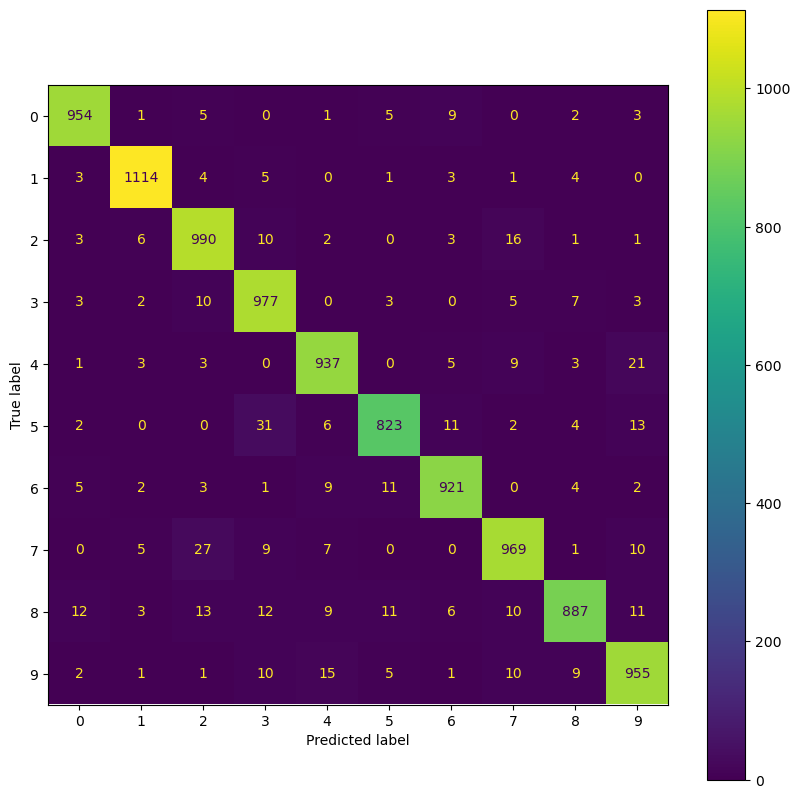

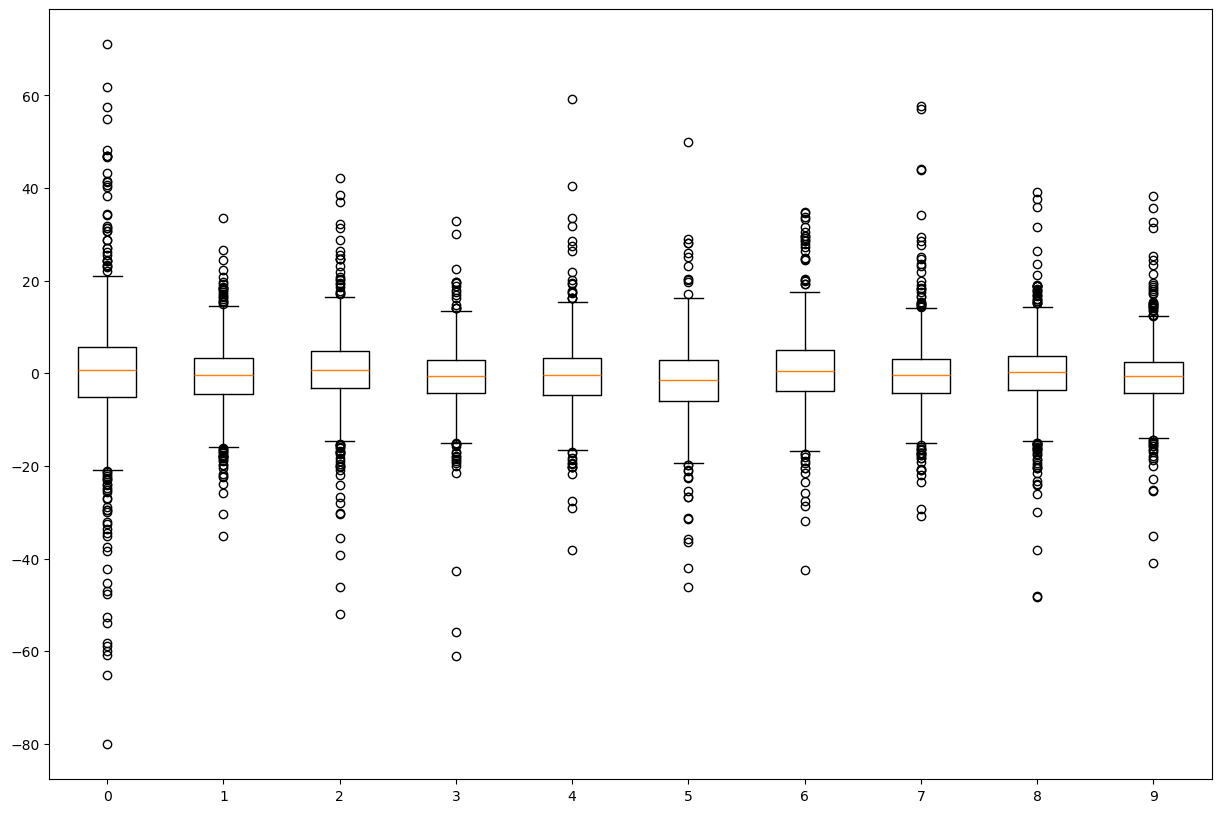

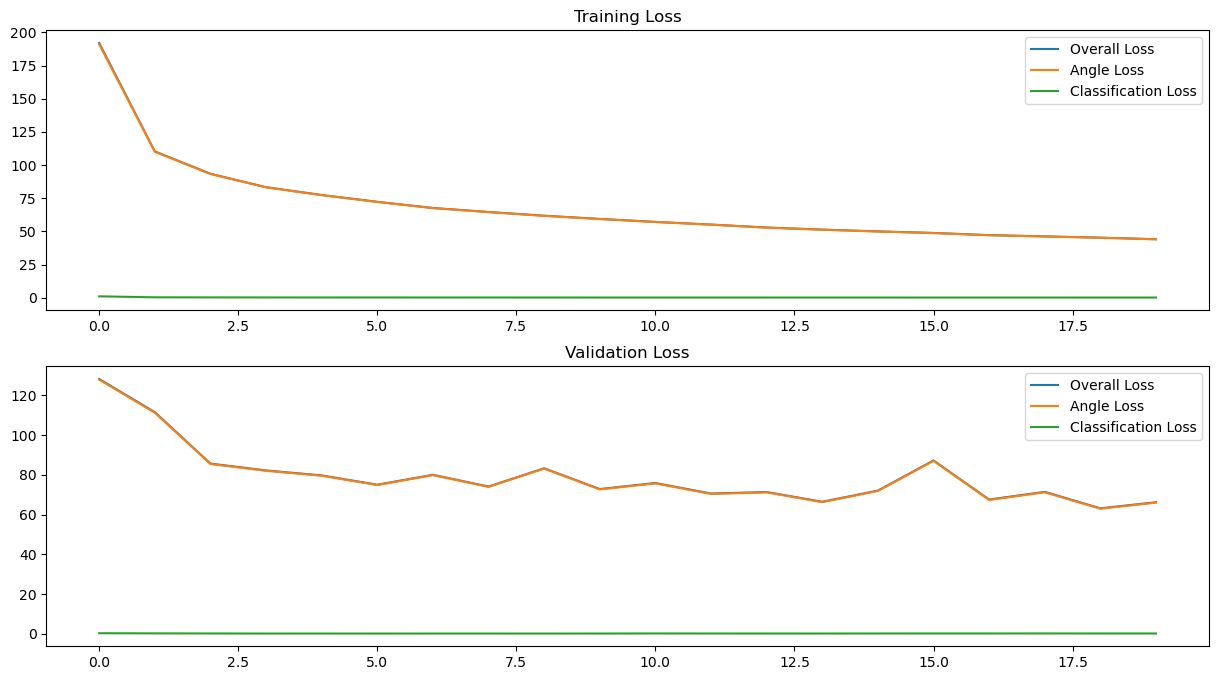

In [8]:
def eval_models(model, x_test, y_test_rot, y_test, history):

    predictions_rot, predictions_label = model.predict(x_test_rot)

    indexes = keras.ops.argmax(predictions_label, axis=1)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

    fig = plt.figure(figsize=[15, 10])
    ax = fig.add_subplot(1, 1, 1)
    data = []
    labels = []
    for i in range(10):
        sample_idx = numpy.array(y_test == i)
        errors = numpy.subtract(predictions_rot[sample_idx, 0], y_test_rot[sample_idx])
        data.append(errors)
        labels.append(str(i))

    ax.boxplot(data, labels=labels);

    fig = plt.figure(figsize=[15, 8])
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(history.history['loss'], label = 'Overall Loss')
    ax.plot(history.history['angle_out_mean_squared_error'], label = 'Angle Loss')
    ax.plot(history.history['class_out_sparse_categorical_crossentropy'], label = 'Classification Loss')
    ax.legend()
    ax.set_title('Training Loss')

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(history.history['val_loss'], label = 'Overall Loss')
    ax.plot(history.history['val_angle_out_mean_squared_error'], label = 'Angle Loss')
    ax.plot(history.history['val_class_out_sparse_categorical_crossentropy'], label = 'Classification Loss')
    ax.legend()
    ax.set_title('Validation Loss')

eval_models(model_cnn, x_test, y_test_rot, y_test, history)

From the above, we can see that we've learnt both tasks fairly well. We can also see though that our losses are in very different scales, our angle loss is roughly 100 times our classification loss. 

## Loss Weights

If we want to change our loss weights, which can help our network consider all tasks equally, again it's trivially simple. We just provide a list (or dictionary) of loss weights to the compile command when we build the model.

In [9]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = layers.Flatten()(x)
x1 = layers.Dense(64, activation='relu')(x)
angle = layers.Dense(1, name='angle_out')(x1)
x2 = layers.Dense(64, activation='relu')(x)
label = layers.Dense(10, name='class_out')(x2)

model_cnn = keras.Model(inputs=inputs, outputs=[angle, label], name='mnist_cnn_multitask_model2')
model_cnn.compile(loss=['mean_squared_error', keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
                  loss_weights=[1, 100],
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['mean_squared_error', keras.losses.SparseCategoricalCrossentropy(from_logits=True)], 
                  jit_compile=False)

history = model_cnn.fit(x_train_rot, [y_train_rot, y_train],
                    batch_size=64,
                    epochs=20,
                    validation_data=(x_test_rot, [y_test_rot, y_test]))

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - angle_out_mean_squared_error: 241.4996 - class_out_sparse_categorical_crossentropy: 1.6089 - loss: 402.3887 - val_angle_out_mean_squared_error: 119.4332 - val_class_out_sparse_categorical_crossentropy: 0.2275 - val_loss: 142.1799
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - angle_out_mean_squared_error: 106.3569 - class_out_sparse_categorical_crossentropy: 0.1851 - loss: 124.8718 - val_angle_out_mean_squared_error: 89.9923 - val_class_out_sparse_categorical_crossentropy: 0.1440 - val_loss: 104.3947
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - angle_out_mean_squared_error: 86.9549 - class_out_sparse_categorical_crossentropy: 0.1359 - loss: 100.5444 - val_angle_out_mean_squared_error: 81.2972 - val_class_out_sparse_categorical_crossentropy: 0.1292 - val_loss: 94.2151
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - angle_out_mean_squared_error: 76.6049 - class_out_sparse_categorical_crossentropy: 0.1063 - loss: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


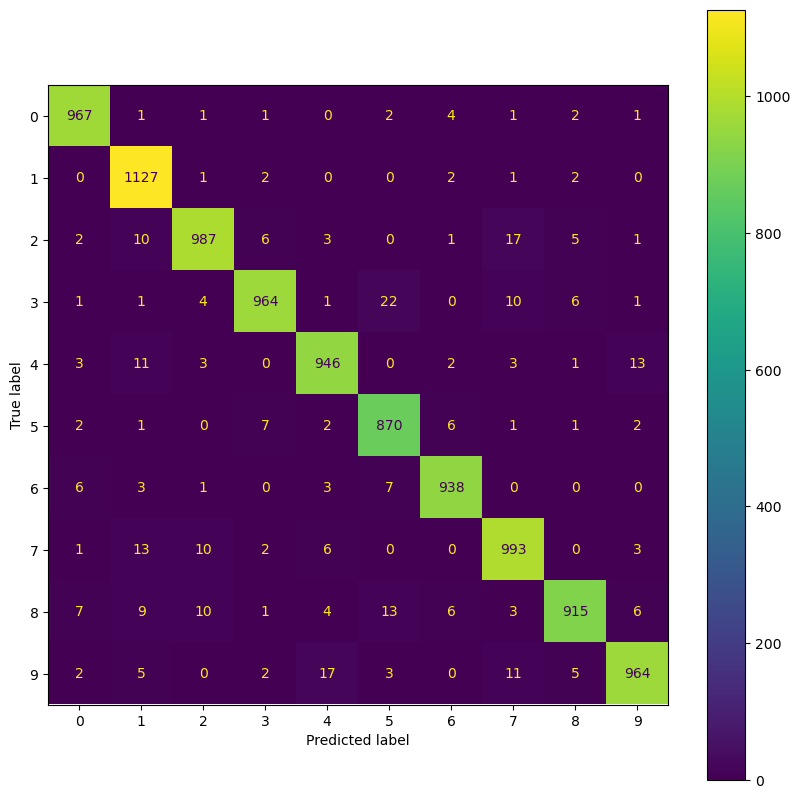

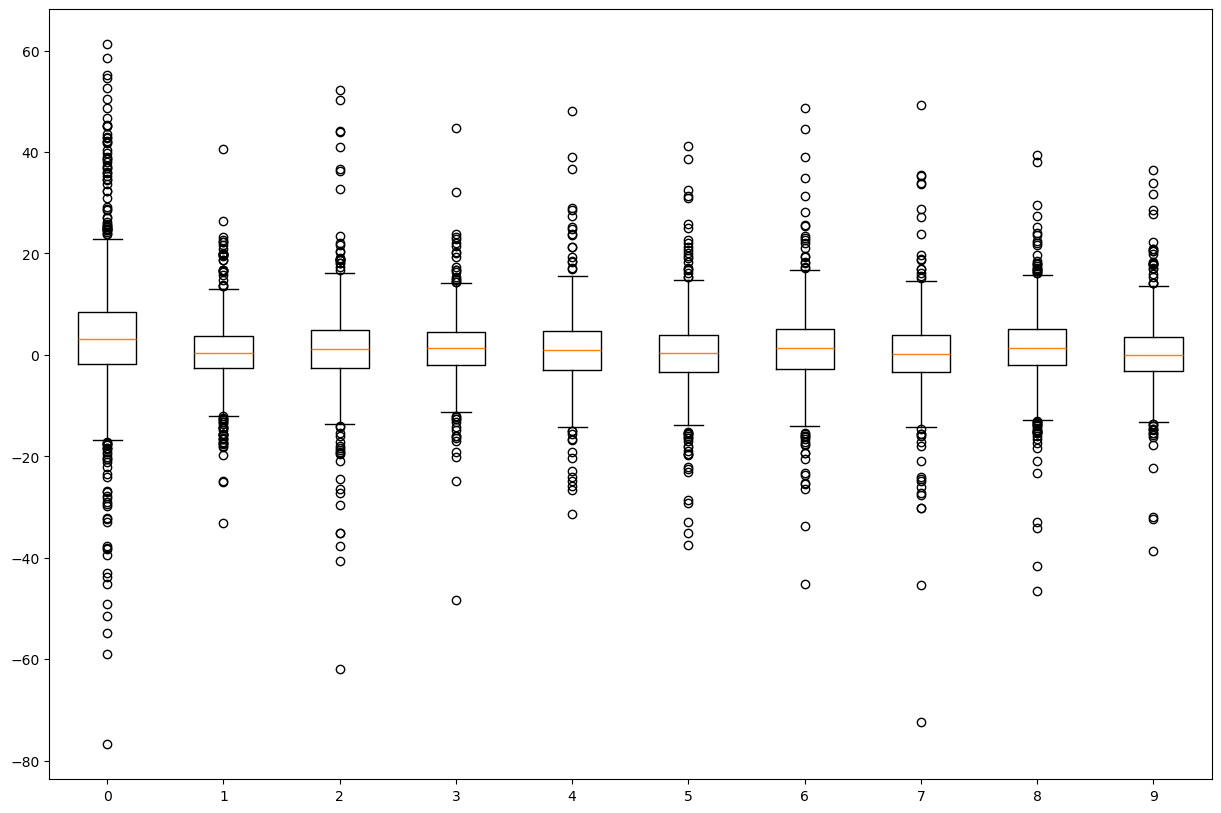

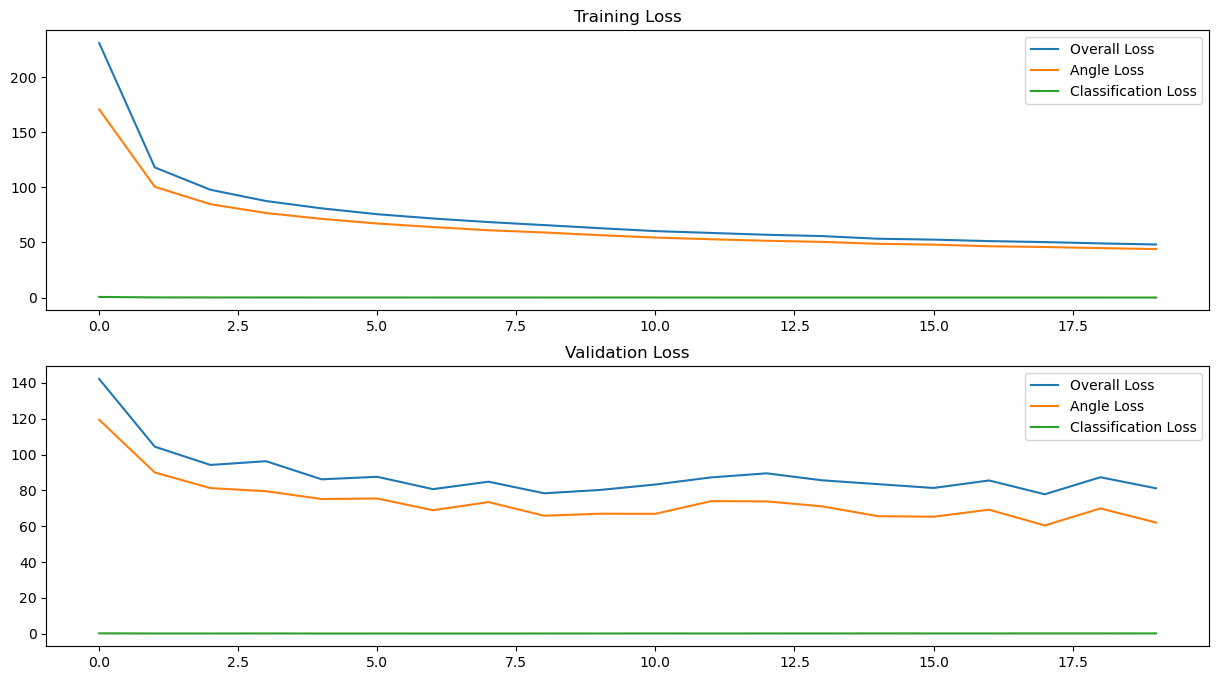

In [10]:
eval_models(model_cnn, x_test, y_test_rot, y_test, history)

Note that the "Classification Loss" line hasn't moved, but there's now more of a gap between the angle and overall lines. The classification loss shows the unweighted loss (i.e. without the $\times 100$), while the overall loss shows the weighted sum. The gap between the overall and angle loss lines makes it clear that the loss weights are being applied.

That said, performance doesn't change much in this case. As much as anything that's a result of the simple task rather than the loss weights not doing anything.

## Final Thoughts

So what have we learnt today?

Multi-task learning is actually quite simple, and can work quite well. The trick is to pick tasks that have something in common. For a dataset like this that's fairly easy, but as the same time there's only so much you can do with digits.

One challenge that we have with other datasets and multiple loss is having labels for each task. This is where things such as auto-encoders, which are self-supervised (i.e. the output is the same as the input) can come in handy.

We've also learnt that setting it all up is actually really easy. You just add another output, specify it's loss, and you're off. This process extends to adding multiple inputs too.